## Example: Covariate shift adaption

In [113]:
## Import Libraries 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score as AUC

We make some data with a clear covariate shift. The labelled training data here is claled $X_{Tr}$, while the data we want to predict is called  $X_{Ts}$

In [114]:
## make some data which has a clear covariate shift
nTr = 1000 # Number of Training examples
nTs = 100 # Number of Testing examples

x1 = 11*np.random.random(nTr) - 6.0 # Length on X axis
x2 = x1**2 + 10*np.random.random(nTr) - 0 # Length on Y axis
X_Tr_C1 = np.c_[x1, x2]

x1 = 11*np.random.random(nTr) - 6.0 # Length on X axis
x2 = x1**2 + 15*np.random.random(nTr) - 15  
X_Tr_C2 = np.c_[x1, x2]

X_Tr=np.concatenate((X_Tr_C1, X_Tr_C2),axis=0)

x1 = 2*np.random.random(nTs)- 6.0
x2 = x1**2 + 10*np.random.random(nTs) - 0
X_Ts_C1 = np.c_[x1, x2]

x1 = 2*np.random.random(nTs)- 6.0
x2 = x1**2 + 15*np.random.random(nTs) - 15
X_Ts_C2 = np.c_[x1, x2]

X_Ts=np.concatenate((X_Ts_C1, X_Ts_C2),axis=0)

zz=np.zeros((nTr,1), dtype=int)
on=np.ones((nTr,1), dtype=int)
Y_Tr=np.concatenate((zz,on), axis=0) 


zz=np.zeros((nTs,1), dtype=int)
on=np.ones((nTs,1), dtype=int)
Y_Ts=np.concatenate((zz,on), axis=0) 

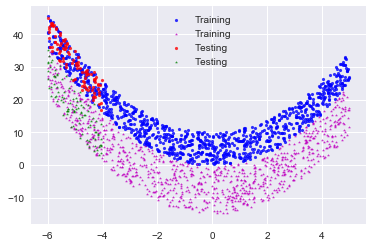

In [115]:
## plot the data

sns.regplot(X_Tr[0:999,0], X_Tr[0:999,1], marker='o', label='Training', fit_reg=False,  color="b", scatter_kws={"s": 10})
sns.regplot(X_Tr[1000:1999,0], X_Tr[1000:1999,1], marker='*', label='Training', fit_reg=False,  color="m", scatter_kws={"s": 10})

sns.regplot(X_Ts[0:99,0], X_Ts[0:99,1], marker='o', label='Testing', fit_reg=False,  color="r", scatter_kws={"s": 10})
sns.regplot(X_Ts[100:199,0], X_Ts[100:199,1], marker='*', label='Testing', fit_reg=False,  color="g", scatter_kws={"s": 10})
plt.legend()
plt.savefig('CovariateShift.png', dpi=300)
plt.show()

In [116]:
X_Tr = pd.DataFrame(X_Tr) # Convert to Dataframe (Training)
X_Ts = pd.DataFrame(X_Ts) # Convert to Dataframe (Testing)

X_Tr['is_z'] = 1 # Assign labels
X_Ts['is_z'] = 0 # Assign labels

X_Tr_Ts = pd.concat( [X_Ts, X_Tr], ignore_index=True, axis=0) # Merge training and testing data

labels = X_Tr_Ts['is_z'].values ## Get labels
X_Tr_Ts = X_Tr_Ts.drop('is_z', axis=1).values # drop coloums as we get the labels
X_Ts, X_Tr = X_Ts.values, X_Tr.values

In [117]:
X_Ts.shape

(200, 3)

In [118]:
# can use a non-linear learner, but make sure to restrict how 
# much it can learn or it will discriminate too well.
clf = RFC(max_depth=2)
# because we can see a learn divide in the above data we 
# could simply use logistic regression here.
# clf = LR()

predictions = np.zeros(labels.shape) # Create an empty array for prediction labels

skf = SKF(n_splits=20, shuffle=True, random_state=1234) # create a cross validation

for fold, (train_idx, test_idx) in enumerate(skf.split(X_Tr_Ts, labels)):
    print('Training discriminator model for fold {}'.format(fold))
    X_train, X_test = X_Tr_Ts[train_idx], X_Tr_Ts[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
        
    clf.fit(X_train, y_train) # fit a random forset (RF)
    probs = clf.predict_proba(X_test)[:, 1] # predict labels using the fitted RF model
    predictions[test_idx] = probs # assign probabilities to predicton array

Training discriminator model for fold 0
Training discriminator model for fold 1
Training discriminator model for fold 2
Training discriminator model for fold 3
Training discriminator model for fold 4
Training discriminator model for fold 5
Training discriminator model for fold 6
Training discriminator model for fold 7
Training discriminator model for fold 8
Training discriminator model for fold 9
Training discriminator model for fold 10
Training discriminator model for fold 11
Training discriminator model for fold 12
Training discriminator model for fold 13
Training discriminator model for fold 14
Training discriminator model for fold 15
Training discriminator model for fold 16
Training discriminator model for fold 17
Training discriminator model for fold 18
Training discriminator model for fold 19


In [119]:
## We'll output the ROC-AUC metric for our classifier as an estimate how much covariate shift this data has.

print('ROC-AUC for Tr and Ts distributions:', AUC(labels, predictions)) # Print the accuracy

ROC-AUC for Tr and Ts distributions: 0.91351


In the predictions array, we just computed the probability of a sample in the full dataset being sample taken from the training distribution ($X_{Tr}$). We'll call this $p(X_{Tr}|D)$. Next we'll use the relationship that $p(X_{Tr}|D) = 1 - p(X_{Ts}|D)$ to estimate $\beta$ for our training samples,

$\beta_i = \frac{p_i(X_{Ts}|D)}{p_i(X_{Tr}|D)} = \frac{1 - p_i(X_{Tr}|D)}{p_i(X_{Tr}|D)} = \frac{1}{p(X_{Tr}|D)} - 1$.

So we now have a method to convert the probability of each point belonging to the training distribution into our sample weights $\beta$. Let's see what these weights look like for the toy problem above.

C:\Users\hr17576\AppData\Local\conda\conda\envs\ENVtensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


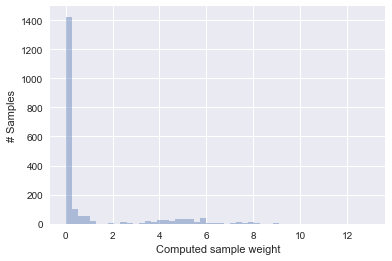

In [120]:
## This is all done to get the weights or importance of each training sample

# first, isolate the training part (recall we joined them above)
predictions_X_Tr = predictions[len(X_Ts):] # Fetch the predictions of X_Tr
weights = (1./predictions_X_Tr) - 1. # 1 divided by 
weights /= np.mean(weights) # we do this to re-normalize the computed log-loss
plt.xlabel('Computed sample weight')
plt.ylabel('# Samples')
sns.distplot(weights, kde=False)
plt.savefig('Weights.png', dpi=300)
plt.show()

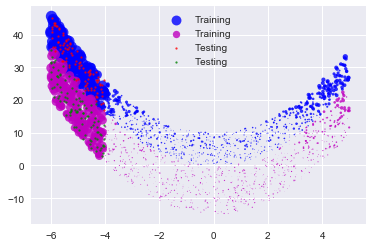

In [121]:
Zsize  = 0.1 + weights*15

sns.regplot(X_Tr[0:999,0], X_Tr[0:999,1], marker='o', color="b", scatter_kws={"s": Zsize[0:999]}, label='Training', fit_reg=False)
sns.regplot(X_Tr[1000:1999,0], X_Tr[1000:1999,1], marker='o', color="m", scatter_kws={"s": Zsize[1000:1999]}, label='Training', fit_reg=False)

sns.regplot(X_Ts[0:99,0], X_Ts[0:99,1], marker='o', color="r", scatter_kws={"s": 5},label='Testing', fit_reg=False)
sns.regplot(X_Ts[100:199,0], X_Ts[100:199,1], marker='o', color="g", scatter_kws={"s": 5},label='Testing', fit_reg=False)
plt.legend()
plt.savefig('Wighted_output.png', dpi=300)

In [122]:
## https://github.com/erlendd/covariate-shift-adaption/blob/master/Supervised%20classification%20by%20covariate%20shift%20adaption.ipynb

In [136]:
## Multiply weights with Training Data
a=np.matrix(X_Tr)
b=np.transpose(np.matrix(weights))
X_Tr_N=np.multiply(a,b)

In [137]:
# Create Labels for it

In [138]:
ze=np.zeros((1000,1), dtype=int)
on=np.ones((1000,1), dtype=int)
Tr_Y=np.concatenate((np.array(ze), np.array(on)), axis=0)
#print(Tr_Y)
Tr_Y = np.ravel(Tr_Y)
print(Tr_Y)

ze=np.zeros((100,1), dtype=int)
on=np.ones((100,1), dtype=int)
Ts_Y=np.concatenate((np.array(ze), np.array(on)), axis=0)
Ts_Y = np.ravel(Ts_Y)
print(Ts_Y)

[0 0 0 ..., 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [134]:
from sklearn import svm
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(X_Tr,Tr_Y)

from sklearn import metrics
metrics.accuracy_score(clf.predict(X_Ts), Ts_Y)

0.61499999999999999

In [139]:
from sklearn import svm
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(X_Tr_N,Tr_Y)

from sklearn import metrics
metrics.accuracy_score(clf.predict(X_Ts), Ts_Y)

0.5